In [3]:
import json
import nltk
import inflect
import tqdm
import time
import requests 
from bs4 import BeautifulSoup as bs
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import numpy as np
import collections
engine = inflect.engine()
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Helper functions

In [4]:
def singularize(word):
    ingr = engine.singular_noun(word)
    return word if (not ingr) else ingr

def clean_ing_word(word) : return singularize(word).lower()

def clean_whole_ing(ing) : return " ".join([clean_ing_word(word) for word in ing.split(" ")])

### load data

In [5]:
recipes = json.load(open("../data/1M/recipe1M_layers/layer1.json"))
det_ingr = json.load(open("../data/1M/det_ingr.json"))

### Filter recipes with only valid ingredients

In [6]:
usda_no_quant_indices = []
usda_no_quant = 0

for index in tqdm.tqdm_notebook(range(len(recipes))) :
    try :
        det_ingr[index]['valid'].index(False)
    except :
        usda_no_quant += 1
        usda_no_quant_indices.append(index)

recipes = [recipes[index] for index in usda_no_quant_indices] 
det_ingr = [det_ingr[index] for index in usda_no_quant_indices]

json.dump(det_ingr, open("../generated/1m_valid_recipes.json", 'w'))
print(str(usda_no_quant) + " recipes contained mappable ingredients and no quant => " + str(100*usda_no_quant/len(recipes)) + "%")


869656 recipes contained mappable ingredients and no quant => 100.0%


### generate ingredients count

All ingredients

In [7]:
ingredients_counter = collections.Counter()

for e, recipe in tqdm.tqdm_notebook(enumerate(recipes)) :
    ingredients_counter.update([c['text'] for c in det_ingr[e]['ingredients']])       
    
json.dump(ingredients_counter.most_common(), open("../generated/1m_ing_count_all.json", 'w'))

now we filter the ingredients to keep the most important ones (those that appear more than thresh=50 times)

In [9]:
common_ing_counts = []

thresh=50

for c in ingredients_counter.most_common() :
    if c[1] >= thresh :
        common_ing_counts.append(c)
    else :
        break
        
print("starting from", len(ingredients_counter.most_common()), "we kept", len(common_ing_counts), "ingredients.")
percentage = 100*len(common_ing_counts)/len(ingredients_counter.most_common())
print("This is equivalent to keeping only " + "{0:.2f}".format(percentage) + "% of the ingredients.")

json.dump(common_ing_counts, open("../generated/1m_ing_count.json", 'w'))

starting from 18077 we kept 5295 ingredients.
This is equivalent to keeping only 29.29% of the ingredients.


### Rewriting recipes with ingredients 

We first write a file with the recipes that contain only usda mappable ingredients, and keep the detected ingredients names, we do not clean them as we already now that a mapping exists for usda.

In [10]:
rep_with_ing =[]

for e, r in tqdm.tqdm_notebook(enumerate(recipes)) :
    ingredients = []
    for ing_index in range(len(r['ingredients'])) :
        ingredients.append(det_ingr[e]['ingredients'][ing_index]['text'])
    
    rep_with_ing.append(ingredients)
    
json.dump(rep_with_ing, open("../generated/1m_usda_recipes.json", 'w'))

### Extracting quantities for recipes

In [9]:
def string_to_float(x) :
    try :
        x = x.split('/')
        if len(x) > 1 :            
            return (float(x[0])/float(x[1]))
        else :
            return float(x[0])
    except :
        raise ValueError("not possible to cast ", x, "to float")
    
def string_to_frac(x) :
    try :
        if '/' in x:
            return string_to_float(x)
        else :
            return(float(x[0]) / float(x[1:]))
    except :
        raise ValueError("not possible to cast ", x, "to float")
    
def fmt_unit(x) :
    return singularize(x.lower())

In [17]:
units = ["bushel", "cup", "dash", "drop", "fl." "oz", "g", "cc", "gram", "gallon", "glass",
    "kg", "liter", "ml", "ounce", "c.", "pinch", "pint", "pound", "lb", "quart",
    "scoop", "shot", "tablespoon", "teaspoon", "tsp", "tbsp"]

def extract_quantity(tags, recipe_index, ingredient_index) : 
    try :
        ingr  = det_ingr[recipe_index]['ingredients'][ingredient_index]['text']
        ingr_first_word = ingr.split(" ")[0]

        if ((len(tags) >= 2) and (tags[0][1] == 'CD')) :

            #nb (nb+ unit) ing
            if ((tags[1][0] == '(') and (len(tags)>6)):
                idx_par = tags.index((')', ')'))            
                quant_in = tags[2:idx_par-1]
                quant=0

                #nb nb 
                if len(quant_in) == 2 :
                    quant = (string_to_float(quant_in[0][0]) + string_to_frac(quant_in[1][0])) / 2
                elif len(quant_in) == 1:
                    quant = string_to_float(quant_in[0][0])

                else :
                    return None

                unit = fmt_unit(tags[idx_par-1][0])            
                return (quant, unit, ingr)


            #nb+ [unit] ing
            else :
                tag1_nb = tags[1][1] == 'CD'
                tag1_to = tags[1][0] == 'to'
                tag1_unit = fmt_unit(tags[1][0]) in units
                tag1_starts_minus = tags[1][0][0] == '-'

                #nb unit ing
                if (tag1_unit) :
                    return (string_to_float(tags[0][0]), fmt_unit(tags[1][0]), ingr)

                #nb nb ...
                elif tag1_nb : 
                    first_nb = string_to_float(tags[0][0]) + string_to_frac(tags[1][0])

                    #nb nb unit ing
                    if fmt_unit(tags[2][0]) in units :
                        return (first_nb, fmt_unit(tags[2][0]), ingr)

                    #nb nb to nb ...
                    elif tags[2][0] == 'to':

                        #nb nb to nb unit ing
                        if fmt_unit(tags[4][0]) in units :
                            return ((first_nb + string_to_float(tags[3][0])) / 2,  fmt_unit(tags[4][0]), ingr)

                        #nb nb to nb nb ...
                        elif tags[4][1] == 'CD' :

                            second_nb = string_to_float(tags[3][0]) + string_to_frac(tags[4][0])
                            average_qt = (first_nb + second_nb) / 2

                            #nb nb to nb nb unit ing
                            if fmt_unit(tags[5][0]) in units :
                                return (average_qt, fmt_unit(tags[5][0]), ingr)

                            #nb nb to nb nb ing
                            else :
                                return (average_qt, "", ingr)

                        #nb nb to nb ing
                        else :
                            return ((first_nb + string_to_float(tags[4][0])) / 2, "", ingr)

                    #nb nb ing
                    else :
                         return (first_nb, "", ingr)   



                #nb -nb ...
                elif tag1_starts_minus :
                    first_nb = (string_to_float(tags[0][0]) + string_to_float(tags[1][0][1:]))/2

                    #nb -nb unit ing
                    if fmt_unit(tags[2][0]) in units :
                        return (first_nb, fmt_unit(tags[2][0]), ingr)

                    #nb -nb ing
                    else :
                        return (first_nb, "", ingr)

                #nb to nb ...
                elif (tag1_to):
                    first_nb = string_to_float(tags[0][0])

                    #nb to nb nb ...
                    if (tags[3][1] == 'CD') :
                        second_nb = string_to_float(tags[2][0]) + string_to_frac([3][0])
                        avg_qt = (first_nb + second_nb) / 2

                        #nb to nb nb unit ing
                        if fmt_unit(tags[4][0]) in units :
                            return (avg_qt, fmt_unit(tags[4][0]), ingr)

                        #nb to nb nb ing
                        else :
                            return (avg_qt, "", ingr)

                    #nb to nb unit ing
                    elif (fmt_unit(tags[3][0]) in units) :
                        second_nb = string_to_float(tags[2][0])
                        avg_qt = (first_nb + second_nb) / 2
                        return (avg_qt, fmt_unit(tags[3][0]), ingr)

                    #nb to nb ing
                    else :
                        second_nb = string_to_float(tags[2][0])
                        avg_qt = (first_nb + second_nb) / 2
                        return (avg_qt, "", ingr)
                #nb ing 
                else :
                    return (string_to_float(tags[0][0]), "", ingr)
    except :
        return None

In [20]:
measurable_indices = []
all_extracted = []
unit_ing = collections.Counter()
measurables = 0
nb_to_try = len(recipes)
sizes = ['large', 'medium', 'small']

for e, r in tqdm.tqdm_notebook(enumerate(recipes[:nb_to_try])) :
    
    extracted = []
    contains_immeasurable = False
    
    for i, ingredient in enumerate(r['ingredients']) :
        
        #remove sizes        
        ingredient['text'] = " ".join([c for c in ingredient['text'].split(" ") if (not c.lower().strip() in sizes)])
        
        #tag the ingredient definition
        tags = nltk.pos_tag(nltk.word_tokenize(ingredient['text']))
        
        raw_ing_to_detect = det_ingr[e]['ingredients'][i]['text']
        ing_to_detect = " ".join([singularize(c) for c in raw_ing_to_detect.split(" ")])

        a = extract_quantity(tags, e, i)

        if a is not None and a[1] != "":
            extracted.append(a)

        else :
            
            #detect units ingredients
            if ((a is not None) \
                and (a[1] == "") \
                and (len(ingredient['text'].split(" ")) > 2) \
                and (len(ing_to_detect.split(" ")) > 0) \
                and (singularize(ingredient['text'].split(" ")[1]).strip() == ing_to_detect.split(" ")[0].strip())) :
                unit_ing.update([ing_to_detect])
                extracted.append(a)
            
            else :
                
                #detect salt (usually nio quantities)
                ing_is_salt = ((('salt', 'NN') in tags) or (('salt', 'NNP') in tags) or (('Salt', 'NN') in tags) or (('Salt', 'NNP') in tags)) 
                
                if not ing_is_salt :
                    contains_immeasurable = True
                    break
                elif ing_is_salt :                    
                    extracted.append((2.5, 'g', 'kosher salt'))            
            
    if not contains_immeasurable :
        all_extracted.append(extracted)
        measurable_indices.append(e)
        measurables+=1
            
            
print(str(measurables) + " recipes contained only mesurable ingredients => " + str(100*measurables/nb_to_try) + "%")


206887 recipes contained only mesurable ingredients => 23.789521373968558%


### Determining ingredients unit quantities
> We stated that a recipe is valid even if the unit of the quantity could not be found, e.g "3 eggs". This sounds like a valid choice by looking at the previous example, but we should nevertheless manually find the weights of the ingredients with no units to compute their nutritional profile. We first select only a subset of those ingredients to shorten the search.

In [40]:
print("There were", len(unit_ing), "distinct ingredients given with no units")

There were 4055 distinct ingredients given with no units


With 4055 ingredients to search, it seems that prunning is more than welcome. Let's look at their counts distribution to come up with a prunning strategy.

In [41]:
print("Those are the 10 most frequent ones : ")
unit_ing.most_common(10)

Those are the 10 most frequent ones : 


[('garlic clove', 44427),
 ('egg yolk', 10697),
 ('egg white', 10519),
 ('red onion', 6791),
 ('green onion', 6114),
 ('red bell pepper', 5397),
 ('bay leaf', 5373),
 ('boneles skinles chicken breast', 5021),
 ('yellow onion', 4617),
 ('egg', 3891)]

<BarContainer object of 4055 artists>

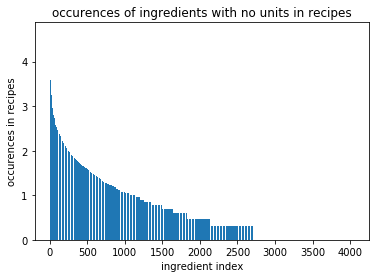

In [43]:
plt.title("occurences of ingredients with no units in recipes")
plt.xlabel("ingredient index")
plt.ylabel("occurences in recipes")
plt.bar(range(len(unit_ing)), [np.log10(c[1]) for c in unit_ing.most_common()])

We see that 1500 ingredients occur only once, and that despite the log axis we still recognize kind of a power law. This is good, because for a fixed number of ingredients, it means we will have to compute less weights to gain accuracy in quantities detection. Because we do not want to bother too much finding weights manually, we choose the first 50 ones and find their corresponding quantities.

In [49]:
fifteenth = unit_ing.most_common()[50]
print("the 50th most frequent ingredient is \'", fifteenth[0], "\' and appears", fifteenth[1], "times")

the 50th most frequent ingredient is ' spring onion ' and appears 625 times


> 625 is still a big number of occurences,but we cannot afford to look for more ingredients.

We first try to detect the weights automatically to gain time. After that, we fill the missing values manually. Note that we do the scrapping for the best 200 ingredients, as it is quite long to run.

### scrap quantities from some website

In [51]:
found = []

for ing in tqdm.tqdm_notebook(unit_ing.most_common()[:200]) :
    
    quantity = 0
    unit = ""
    
    try :
        
        url_sing = "https://hannaone.com/Recipe/weight" + str(ing[0]).replace(" ", "") +".html"
        url_plur = "https://hannaone.com/Recipe/weight" + str(ing[0]).replace(" ", "") +"s.html"
        
        try :
            req = urllib.request.Request(url_sing, headers={'User-Agent': 'Mozilla/5.0'})
            html = urllib.request.urlopen(req)
            res = bs(html.read(),"html5lib")
            trs = res.find("table").findAll("tr")
        except :
            try :
                req = urllib.request.Request(url_plur, headers={'User-Agent': 'Mozilla/5.0'})
                html = urllib.request.urlopen(req)
                res = bs(html.read(),"html5lib")
                trs = res.find("table").findAll("tr")
            except Exception as e:
                raise ValueError('The ingredient has no matching url')
        
        found_medium = False
        found_some = False
        to_append = []
        
        for tr in trs[1:] :
            td = tr.find("td")
            
            if td is not None :

                if (('large' in td.text.lower() and (not found_medium)) or (('medium' in td.text.lower()) and not found_medium)) :
                    tds = tr.findAll("td")

                    weight = tds[2].text.split("-")[-1].strip()

                    if 'g' in weight :
                        quantity  = float(weight[:-1])
                        unit = 'g'
                        to_append = (ing[0], (quantity, unit))
                        found_some = True

                    elif 'oz'in weight :
                        quantity  = float(weight[:-2])
                        unit = 'oz'
                        to_append = (ing[0], (quantity, unit))
                        found_some = True


                    if td.text.lower() == 'medium' :
                        found_medium = True  
                    
        if found_some :
            found.append(to_append)
            
            if found_medium :
                print(ing[0], ", medium : ", to_append)
            else :
                print(ing[0], ", large : ", to_append)
             
    except Exception as e: 
        pass

green onion , medium :  ('green onion', (15.0, 'g'))
egg , medium :  ('egg', (44.0, 'g'))
onion , medium :  ('onion', (110.0, 'g'))
potato , medium :  ('potato', (213.0, 'g'))
tomato , large :  ('tomato', (20.0, 'g'))
apple , medium :  ('apple', (182.0, 'g'))
banana , medium :  ('banana', (118.0, 'g'))
lemon , large :  ('lemon', (84.0, 'g'))
cucumber , large :  ('cucumber', (35.0, 'g'))
orange , medium :  ('orange', (131.0, 'g'))



### quantities found
We found 10 ingredients which is quite a poor result, considering that some results even need to be corrected (How could a potato possibly be ten times heavier than a tomato ?). Below, we recap the quantities per ingredient. 

In [56]:
unit_quantities = [('garlic clove', (3, 'g')),
 ('egg yolk', (17, 'g')),
 ('egg white', (33, 'g')),
 ('red onion', (110, 'g')),
 ('green onion', (110, 'g')),
 ('red bell pepper', (100, 'g')),
 ('bay leaf', (0.5, 'g')),
 ('boneles skinles chicken breast', (300, 'g')),
 ('yellow onion', (110, 'g')),
 ('egg', (50, 'g')),
 ('chicken breast', (250, 'g')),
 ('onion', (110, 'g')),
 ('green bell pepper', (100, 'g')),
 ('green pepper', (15, 'g')),
 ('boneles skinles chicken breast half', (150, 'g')),
 ('sweet potato', (170, 'g')),
 ('cinnamon stick', (5, 'g')),
 ('white onion', (110, 'g')),
 ('red pepper', (15, 'g')),
 ('celery rib', (40, 'g')),
 ('jalapeno pepper', (14, 'g')),
 ('vanilla bean', (5, 'g')),
 ('sweet onion', (110, 'g')),
 ('flour tortilla', (34, 'g')),
 ('baking potato', (170, 'g')),
 ('pork chop', (150, 'g')),
 ('russet potato', (170, 'g')),
 ('bell pepper', (100, 'g')),
 ('plum tomato', (170, 'g')),
 ('whole clove', (3, 'g')),
 ('red potato', (170, 'g')),
 ('whole chicken', (2267, 'g')),
 ('yellow bell pepper', (100, 'g')),
 ('boneles chicken breast', (300, 'g')),
 ('chicken thigh', (85, 'g')),
 ('corn tortilla', (34, 'g')),
 ('minced garlic clove', (3, 'g')),
 ('chicken bouillon cube', (5, 'g')),
 ('fennel bulb', (235, 'g')),
 ('butternut squash', (500, 'g')),
 ('rom tomato', (170, 'g')),
 ('ice cube', (28, 'g')),
 ('carrot', (72, 'g')),
 ('whole chicken breast', (300, 'g')),
 ('Spanish onion', (0, 'g')),
 ('potato', (170, 'g')),
 ('tomato', (170, 'g')),
 ('Granny Smith apple', (150, 'g')),
 ('apple', (150, 'g')),
 ('chicken breast half', (150, 'g'))]

#create dictionnary
unit_quantities_dict = dict()
for ing in unit_quantities :
    unit_quantities_dict[ing[0]] = ing[1]
    
json.dump(unit_quantities, open("../generated/1m_unit_quantities.json", 'w'))

### recipes with both quantities and usda id for all ingredients

In [58]:
all_extracted[0]

[(1.0, 'c.', 'elbow macaroni'),
 (1.0, 'c.', 'American cheese'),
 (0.5, 'c.', 'celery'),
 (0.5, 'c.', 'green peppers'),
 (3.0, 'tbsp', 'pimentos'),
 (0.5, 'c.', 'mayonnaise'),
 (1.0, 'tbsp', 'vinegar'),
 (0.75, 'teaspoon', 'salt'),
 (0.5, 'teaspoon', 'dry dill weed')]

In [60]:
usda_and_quant_recipes = []
count = 0

for r in tqdm.tqdm_notebook(all_extracted) :
    ingredients_entries = []
    all_actually_measurable = True
    
    for ing in r :
        if ing[1] == "" :
            cleaned_eq = clean_whole_ing(ing[2])
            
            if cleaned_eq in unit_quantities_dict.keys() :
                unit_quant = unit_quantities_dict[cleaned_eq]
                ingredients_entries.append((unit_quant[0], unit_quant[1], ing[2]))
            
            else :
                all_actually_measurable = False
                break
        else :
            ingredients_entries.append(ing)
            
    if all_actually_measurable :
        usda_and_quant_recipes.append(ingredients_entries)
        count += 1
                        
        
print(str(count) + " recipes contained actually measurable ingredients => " + str(100*count/len(all_extracted)) + "%")
json.dump(usda_and_quant_recipes, open("../generated/1m_quant_usda_recipes.json", 'w'))


179410 recipes contained actually measurable ingredients => 86.71883685296804%
